### Thien Win
BrainStation Data Science Capstone <br>
April 2022 <br>

</br>

##### Notebook Table of Contents: <br>
[1] Data Scraping and Wrangling <br>
<b>[2] CycleGAN Training </b><br>
[3] Model Evaluation <br>
[4] FID Score <br>
<hr>

### [2] CycleGAN Training

##### Recommended Computing: Google Colab Pro(+)

<hr>

#### Introduction

Continuing from the previous notebook `[1] Data Scraping and Wrangling`, I have successfully doubled the amount of training Studio Ghibli images by mirroring the images. We are now ready to construct and train the cycleGAN model and separated a test and train set.

This notebook is meant to be run and trained using Google Colab Pro or Pro+ running on High RAM. Training for this model took more than 12.5 hours for the 100 epoch utilizing a personal Colab Pro+ account. Training verbosity was included in this notebook for readers to see that it successfully trained.

During training, model weights were saved for further analysis in downstream notebooks. For training on Google Colab, the image data should either be uploaded to the local runtime or to a Google Drive. In my specific case, I mounted a personal Google Drive to the runtime for training, accessing the images through the runtime from the Drive.

I have included the following Drive link (expiring 4/30/2022) that contains the image data for training as well as the notebooks. When attempting to train this notebook in Colab, ensure that the path for referencing data location reflects where the images are stored.   

Through the process of creating this project, several functions and methods were discovered and populated in two separate files. This allowed for a cleaner end notebook. I will start by importing the modules and libraries needed, including the functions found in `cycleGAN_functions.py`.

ADVISORY: Make `cycleGAN_functions.py` is located in local runtime folder.

In [1]:
#used during training on Colab
#image files and notebook are located in the same drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 15.4 MB/s 


In [4]:
#used for instance normalization
import tensorflow_addons as tfa

In [5]:
#import all functions and model from created file
from cycleGAN_functions import *

<hr>

#### Creating Studio Ghibli Dataset

With the directory path of the Studio Ghibli images data set, we will import this data directly into a dataset utilizing the specific Keras function `image_dataset_from_directory` method. 

In [6]:
train_SG = tf.keras.utils.image_dataset_from_directory(
        '/content/drive/MyDrive/cycleGAN_deliveryservice/data/SG/trainA', #be mindful of the directory path the data is stored
        labels=None,
        label_mode=None,
        class_names=None,
        color_mode='rgb',
        batch_size=None,
        image_size=(1038, 1920), #original image size
        shuffle=True,
        seed=123,
        validation_split=None,
        subset=None,
        interpolation='bilinear',
        follow_links=True,
        crop_to_aspect_ratio=False
    )

Found 1536 files belonging to 1 classes.


We can inspect the sample image as follows:

In [7]:
#sample next SG img in dataset. may take ~1-2min
example_SG = next(iter(train_SG))

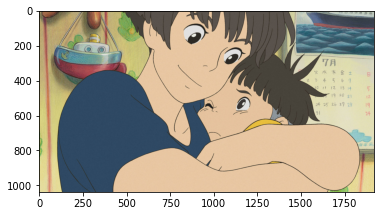

In [8]:
#show example of raw SG img. this may take about a minute or two to run 
plt.imshow(tf.keras.utils.array_to_img(example_SG, data_format=None, scale=True, dtype=None))
plt.show()

We can see that the original source image comes in correctly at the original size. Using the preprocessing functions defined in the `cycleGAN_functions.py` file and imported into this notebook earlier, we will apply those transformations to the Studio Ghibli dataset by caching and then mapping the preprocess functions to each element in the dataset.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000
BATCH_SIZE = 1

train_SG = train_SG.cache().map(
    preprocess_train_SG, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

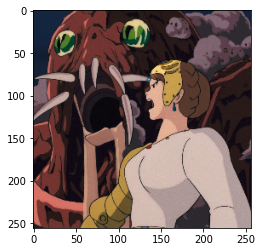

In [10]:
#resample new SG img
sample_SG = next(iter(train_SG))

#show sample of SG img. this may take about minute or two to run
plt.imshow(tf.keras.utils.array_to_img(sample_SG[0], data_format=None, scale=True, dtype=None))
plt.show()

The new sampled image above shows that the images in the dataset have been transformed by observing the reduced size of the image.
<hr>

#### Creating Photo Dataset

I will now create the photo dataset using the same method as before. The data was received already split into a test and train set and leave that as is.

In [11]:
train_photo = tf.keras.utils.image_dataset_from_directory(
        '/content/drive/MyDrive/cycleGAN_deliveryservice/data/photos/trainB', #be mindful of the directory path the data is stored
        labels=None,
        label_mode=None,
        class_names=None,
        color_mode='rgb',
        batch_size=None,
        image_size=(256,256), #original photo size
        shuffle=True,
        seed=123,
        validation_split=None,
        subset=None,
        interpolation='bilinear',
        follow_links=True,
        crop_to_aspect_ratio=False
    )

Found 6287 files belonging to 1 classes.


In [12]:
test_photo = tf.keras.utils.image_dataset_from_directory(
        '/content/drive/MyDrive/cycleGAN_deliveryservice/data/photos/testB', #be mindful of the directory path the data is stored
        labels=None,
        label_mode=None,
        class_names=None,
        color_mode='rgb',
        batch_size=None,
        image_size=(256,256),
        shuffle=True,
        seed=123,
        validation_split=None,
        subset=None,
        interpolation='bilinear',
        follow_links=True,
        crop_to_aspect_ratio=False
    )

Found 751 files belonging to 1 classes.


From amount of photograph images, we have significantly less Studio Ghibli images to train the model on.

We can inspect a sample photos as follows:

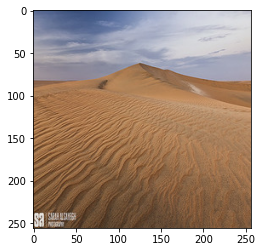

In [13]:
#sample next photo in dataset
example_photo = next(iter(train_photo))

#show example of raw SG img. this may take about minute or two to run
plt.imshow(tf.keras.utils.array_to_img(example_photo, data_format=None, scale=True, dtype=None))
plt.show()

Once again, using the preprocessing functions defined in the `cycleGAN_functions.py` file and imported into this notebook earlier, we will apply those transformations to the photo dataset by caching and then mapping the preprocess functions to each element in the dataset. The preprocessing of photographs really takes into account normalizing the images since it is of an already desired size and kept for consistency sake and potential future modifications

In [14]:
#transform train and test photo dataset

train_photo = train_photo.cache().map(
    preprocess_train_photo, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_photo = test_photo.map(
    preprocess_test_photo, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

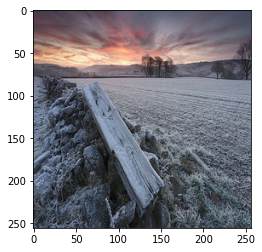

In [15]:
#sample new photo
sample_photo = next(iter(train_photo))

#show sample of to photo. this may take about minute or two to run
plt.imshow(tf.keras.utils.array_to_img(sample_photo[0], data_format=None, scale=True, dtype=None))
plt.show()

From the sample photo above, we can not be sure whether the preprocessing methods took hold. We can confirm this my checking that the sample photo array is between -1 and 1 as defined in the function.

In [16]:
sample_photo

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[-0.42745095, -0.5294118 , -0.3960784 ],
         [-0.42745095, -0.5294118 , -0.3960784 ],
         [-0.44313723, -0.5294118 , -0.40392154],
         ...,
         [-0.46666664, -0.41960782, -0.24705881],
         [-0.46666664, -0.41960782, -0.24705881],
         [-0.46666664, -0.41960782, -0.24705881]],

        [[-0.41960782, -0.5294118 , -0.41176468],
         [-0.42745095, -0.52156866, -0.41176468],
         [-0.4352941 , -0.5294118 , -0.41960782],
         ...,
         [-0.47450978, -0.42745095, -0.25490195],
         [-0.47450978, -0.42745095, -0.25490195],
         [-0.47450978, -0.42745095, -0.25490195]],

        [[-0.3960784 , -0.5294118 , -0.40392154],
         [-0.41960782, -0.5294118 , -0.41176468],
         [-0.41960782, -0.5294118 , -0.41176468],
         ...,
         [-0.46666664, -0.41176468, -0.26274508],
         [-0.46666664, -0.41176468, -0.26274508],
         [-0.46666664, -0.41176468, -0.2627450

Looks like the preprocessing of the photo dataset took hold. I will now proceed to building the cycleGAN.
<hr>

#### Define Generator and Discriminator

The first step is to define the generator and discriminator as one that converts photos to be in Studio Ghibli style, one that converts the image back to a photo and the associated discriminators.

In [17]:
strategy = tf.distribute.get_strategy()

with strategy.scope():
    SG_generator = Generator() # transforms photos to SG-type images
    photo_generator = Generator() # transforms SG images to be more like photos

    SG_discriminator = Discriminator() # differentiates real SG images and generated SG images
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

We want to test the Studio Ghibli generator on a sample photo to make sure that it is working. Since the generator has not been trained yet. We should not expect anything meaningful from the result but want to perform a sanity check that it works. 

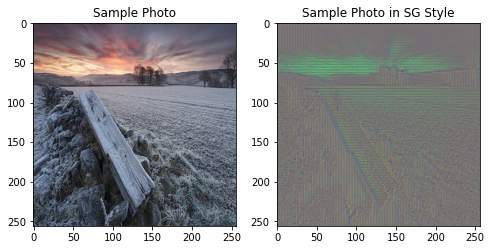

In [18]:
#test the generator. this may take a minute to run
to_SG = SG_generator(sample_photo)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.title('Sample Photo')
plt.imshow(tf.keras.utils.array_to_img(sample_photo[0], data_format=None, scale=True, dtype=None))

plt.subplot(1, 2, 2)
plt.title('Sample Photo in SG Style')
plt.imshow(tf.keras.utils.array_to_img(to_SG[0], data_format=None, scale=True, dtype=None))
plt.show()
#generator is not trained yet so we shouldn't expect anything meaningful

From the above image plots, the creation of the generator was successful.
<hr>

#### Loss Functions

As part of the cycleGAN, there are 4 loss functions to account for:

   - Generator Loss
   - Discriminator Loss
   - Cycle Consistency Loss
   - Identity Loss
   
The major difference between other GANs and the power of the cycleGAN, lies in the cycle consistency loss. This loss reduces the space of possible mapping functions by enforcing forward and backwards consistency which encourages things like colors are preserved. This is done by comparing the converted photo to Studio Ghibli style image and with the same image, converted back to a photo. In comparing this image with the original, the cycle consistency loss is calculated. Intuitively, if a English sentence were to be translated into another language, if asked for that same sentenced to be translated back in English, it should be the original sentence.

Let's proceed with defining these 4 loss functions. 

In [23]:
#define discriminator loss function

with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [24]:
#define generator loss function

with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [25]:
#define cycle consistency loss function

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [26]:
#define identity consistency loss function

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

<hr>

#### Optimizers

As a final component for the cycleGAN model, the optimizer needs to be defined. Per the original cycleGAN paper, the optimizer will be defined as the Adam optimizer with a learning rate of 0.0002 and a beta_1 value of 0.5.

In [27]:
with strategy.scope():
    SG_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    SG_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

<hr>

#### Building the CycleGAN

As a recap thus thus far, I have built the following components to be used in the cycleGAN.

   - SG Generator and Discriminator and respective optimizers
   - Photo Generator and Discriminator and respectiv optimizers
   - Generator Loss Function
   - Discriminator Loss Function
   - Cycle Consistency Loss Function
   - Identity Loss Function
   
Putting this all together, the cycleGAN model can be built and compiled as follows:

In [28]:
class CycleGan(keras.Model):
    def __init__(
        self,
        SG_generator,
        photo_generator,
        SG_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__() #temporary object that allows us to access methods of the base class
        self.SG_gen = SG_generator
        self.p_gen = photo_generator
        self.SG_disc = SG_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        SG_gen_optimizer,
        p_gen_optimizer,
        SG_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile() #temporary object that allows us to access methods of the base class
        self.SG_gen_optimizer = SG_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.SG_disc_optimizer = SG_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_SG, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to SG back to photo
            fake_SG = self.SG_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_SG, training=True)

            # SG to photo back to SG
            fake_photo = self.p_gen(real_SG, training=True)
            cycled_SG = self.SG_gen(fake_photo, training=True)

            # generating itself
            same_SG = self.SG_gen(real_SG, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_SG = self.SG_disc(real_SG, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_SG = self.SG_disc(fake_SG, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            SG_gen_loss = self.gen_loss_fn(disc_fake_SG)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_SG, cycled_SG, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_SG_gen_loss = SG_gen_loss + total_cycle_loss + self.identity_loss_fn(real_SG, same_SG, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            SG_disc_loss = self.disc_loss_fn(disc_real_SG, disc_fake_SG)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        SG_generator_gradients = tape.gradient(total_SG_gen_loss,
                                                  self.SG_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        SG_discriminator_gradients = tape.gradient(SG_disc_loss,
                                                      self.SG_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.SG_gen_optimizer.apply_gradients(zip(SG_generator_gradients,
                                                 self.SG_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.SG_disc_optimizer.apply_gradients(zip(SG_discriminator_gradients,
                                                  self.SG_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "SG_gen_loss": total_SG_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "SG_disc_loss": SG_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

#### Training the CycleGAN

In [29]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        SG_generator, photo_generator, SG_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        SG_gen_optimizer = SG_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        SG_disc_optimizer = SG_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

As mentioned earlier in the notebook, it is not advised to try to run the training of this model locally as it is computationally taxing. My computer, for example, would not allow me to run it in which it would claim it could not allocate enough computing power to accomplish the task. It is recommended that Google Colab Pro+ or some online computing resource (ie AWS, Azure, etc) be used for this step. 

The verbose output as the model was training was included in this notebook.

In addition, model checkpoints were saved to a local Colab runtime every other and downloaded afterwards.

Let's start training!

In [31]:
#Training code that was conducted on Colab. Since we have the checkpoints, we will explore weights and sample images
#from the different epochs.

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/train/train-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=False,
                                                 verbose=1, save_freq=1536*2)

#Checkpoints will be saved to the local runtime in Colab
# Save the weights using the `checkpoint_path` format
cycle_gan_model.save_weights(checkpoint_path.format(epoch=0))

cycle_gan_model.fit(
    tf.data.Dataset.zip((train_SG, train_photo)),
    epochs=100, verbose=True, callbacks=[cp_callback]
)

Epoch 1/100
1536/1536 [==============================] - 380s 244ms/step - SG_gen_loss: 3.4807 - photo_gen_loss: 3.3197 - SG_disc_loss: 0.5657 - photo_disc_loss: 0.6243
Epoch 2/100
1535/1536 [============================>.] - ETA: 0s - SG_gen_loss: 3.4041 - photo_gen_loss: 3.1754 - SG_disc_loss: 0.5346 - photo_disc_loss: 0.6138
Epoch 2: saving model to /content/train/train-0002.ckpt
1536/1536 [==============================] - 385s 247ms/step - SG_gen_loss: 3.4043 - photo_gen_loss: 3.1756 - SG_disc_loss: 0.5345 - photo_disc_loss: 0.6137
Epoch 3/100
1536/1536 [==============================] - 382s 245ms/step - SG_gen_loss: 3.3929 - photo_gen_loss: 3.1489 - SG_disc_loss: 0.5347 - photo_disc_loss: 0.6025
Epoch 4/100
1535/1536 [============================>.] - ETA: 0s - SG_gen_loss: 3.2752 - photo_gen_loss: 3.0917 - SG_disc_loss: 0.5432 - photo_disc_loss: 0.5963
Epoch 4: saving model to /content/train/train-0004.ckpt
1536/1536 [==============================] - 386s 249ms/step - SG_gen_l

Training utilizing this method took about 12.5 hours to complete for the method I took as described above. We will explore the loss functions and image quality in notebook `[3] Model Valuation`.

Let's perform a quick test to see that the trained generator produces images that differs from the original import at the least, and hopefully leaning more to a Studio Ghibli animation style.  

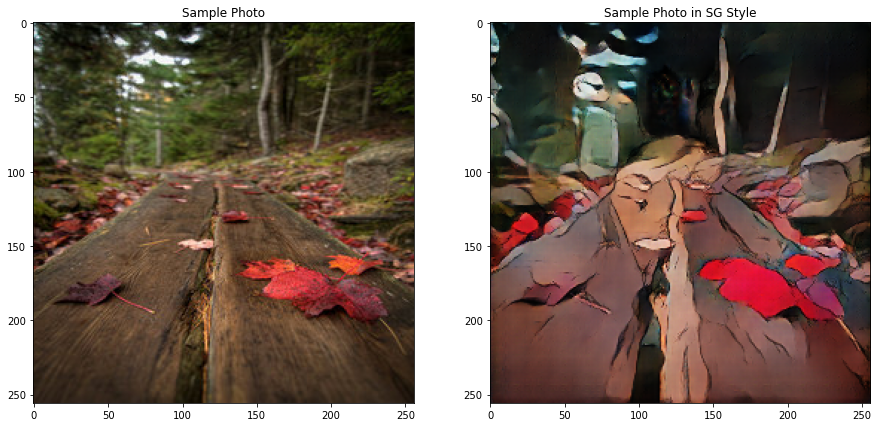

In [40]:
#Observing results from training on Colab for generator trained to epoch 100

sample_photo = next(iter(test_photo))
to_SG = SG_generator(sample_photo)

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.title('Sample Photo')
plt.imshow(tf.keras.utils.array_to_img(sample_photo[0], data_format=None, scale=True, dtype=None))

plt.subplot(1, 2, 2)
plt.title('Sample Photo in SG Style')
plt.imshow(tf.keras.utils.array_to_img(to_SG[0], data_format=None, scale=True, dtype=None))

The generated image is clearly different than the original and resembles a more animated look than realistic photo from a subjective point of view. 

The next step I took was to download the saved checkpoints for analysis on my local machine in following notebooks. The saved checkpoints for the approach I took saved to the local runtime on Colab in a separate 'train' folder. This folder needs to be zipped for ease of downloading as follows:

In [33]:
#used to zip and export files while training on Colab

from google.colab import files


In [34]:
#zip files before downloading off Colab
!zip -r /content/train.zip /content/train 

#after files have been zipped, right click on zipped filed in local runtime on left hand side to download

  adding: content/train/ (stored 0%)
  adding: content/train/train-0066.ckpt.data-00000-of-00001 (deflated 29%)
  adding: content/train/train-0074.ckpt.index (deflated 81%)
  adding: content/train/train-0098.ckpt.data-00000-of-00001 (deflated 30%)
  adding: content/train/train-0034.ckpt.index (deflated 81%)
  adding: content/train/train-0002.ckpt.index (deflated 81%)
  adding: content/train/train-0070.ckpt.data-00000-of-00001 (deflated 29%)
  adding: content/train/train-0088.ckpt.data-00000-of-00001 (deflated 30%)
  adding: content/train/train-0040.ckpt.data-00000-of-00001 (deflated 26%)
  adding: content/train/train-0038.ckpt.data-00000-of-00001 (deflated 25%)
  adding: content/train/train-0050.ckpt.index (deflated 81%)
  adding: content/train/train-0038.ckpt.index (deflated 81%)
  adding: content/train/train-0042.ckpt.data-00000-of-00001 (deflated 26%)
  adding: content/train/train-0000.ckpt.index (deflated 81%)
  adding: content/train/train-0048.ckpt.index (deflated 81%)
  adding: c

Once the folder has been zipped, it was downloaded to my local machine from the Colab runtime. 

In [ ]:
files.download('/content/train.zip')

<hr>

#### Conclusion

In this notebook, we uploaded the images into datasets, transformed the datasets utilizing previous defined preprocessing methods, built and trained our cycleGAN and confirm output from the generator. The next step in the process is to evaluate generated images both subjective and objectively. Refer to the next notebook [3] Evaluation and Metrics for my findings there.

For future iteration improvement, I would like to include a verbose output for the cycle consistency loss as the model trains that could be used for model diagnosis. For future iterations, a ResNet based generator may be employed instead of the UNet based one as recommended in the original paper to see difference in generated image fidelity. 